In this project, we will build an image caption generator to load a random image and give some captions describing the image. We will use Convolutional Neural Network (CNN) for image feature extraction and Long Short-Term Memory Network (LSTM) for Natural Language Processing (NLP).

## Dataset Information

The objective of the project is to predict the captions for the input image. The dataset consists of 8k images and 5 captions for each image. The features are extracted from both the image and the text captions for input.

The features will be concatenated to predict the next word of the caption. CNN is used for image and LSTM is used for text. BLEU Score is used as a metric to evaluate the performance of the trained model.

## Import Modules

First, we have to import all the basic modules we will be needing for this project.

* <b>os</b> - used to handle files using system commands.

* <b>pickle</b> - used to store numpy features extracted

* <b>numpy</b> - used to perform a wide variety of mathematical operations on arrays

* <b>tqdm</b>- progress bar decorator for iterators. Includes a default range iterator printing to stderr.

* <b>VGG16, preprocess_input</b> - imported modules for feature extraction from the image data

* <b>load_img, img_to_array</b> - used for loading the image and converting the image to a numpy array

* <b>Tokenizer</b> - used for loading the text as convert them into a token

* <b>pad_sequences</b> - used for equal distribution of words in sentences filling the remaining spaces with zeros

* <b>plot_model</b> - used to visualize the architecture of the model through different images

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now we must set the directories to use the data.

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

We have to load and restructure the model.

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

* Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results

* By preference you may include more layers, but for quicker results avoid adding the unnecessary layers

Now we extract the image features and load the data for preprocess.

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

* Dictionary <b>features</b> is created and will be loaded with the extracted features of image data

* <b>load_img(img_path, target_size=(224, 224))</b> - custom dimension to resize the image when loaded to the array

* <b>image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))</b> - reshaping the image data to preprocess in a RGB type image

* <b>model.predict(image, verbose=0)</b> - extraction of features from the image

* <b>img_name.split('.')[0]</b> - split of the image name from the extension to load only the image name

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

* Extracted features are not stored in the disk, so re-extraction of features can extend running time

* Dumps and store your dictionary in a pickle for reloading it to save time

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

* Load all your stored feature data to your project for quicker runtime

## Load the Captions Data

Let us store the captions data from the text file.

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Now we split and append the captions data with the image.

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

* Dictionary <b>mapping</b> is created with key as <b>image_id</b> and values as the corresponding caption text

* Same image may have multiple captions, <b>if image_id not in mapping: mapping[image_id] = []</b> creates a list for appending captions to the corresponding image

Now let us see the number of images loaded.

In [9]:
len(mapping)

8091

## Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

* Defined to clean and convert the text for quicker process and better results

Let us visualize the text before and after cleaning.

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

* Words with one letter was deleted

* All special characters were deleted

* 'startseq' and 'endseq' tags were added to indicate the start and end of a caption for easier processing

Next we will store the preprocessed captions into a list.

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

* Number of unique captions stored

Let us see the first ten captions.

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Now we start processing the text data.

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
import json

# Save tokenizer configuration and vocabulary
tokenizer_config = tokenizer.to_json()
with open("tokenizer_config.json", "w", encoding="utf-8") as config_file:
    config_file.write(json.dumps(tokenizer_config))

In [19]:
vocab_size

8485

* Number of unique words

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

* Finding the maximum length of the captions, used for reference for the padding sequence

## Train Test Split

After preprocessing the data now we will train, test and split.

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

* Depending on the data size it can crash your session if you don't have enough memory on your system. Creating and loading the data on a batch is very helpful if you have less than 16 GB of memory

Explanatory example of the sequence split into pairs.

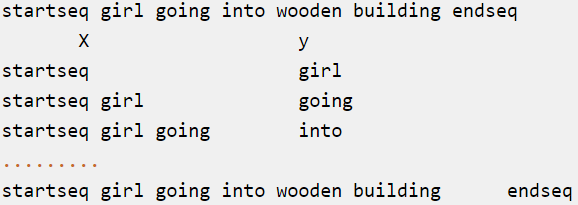

Now we will define a batch and include the padding sequence.

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

* Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results

## Model Creation

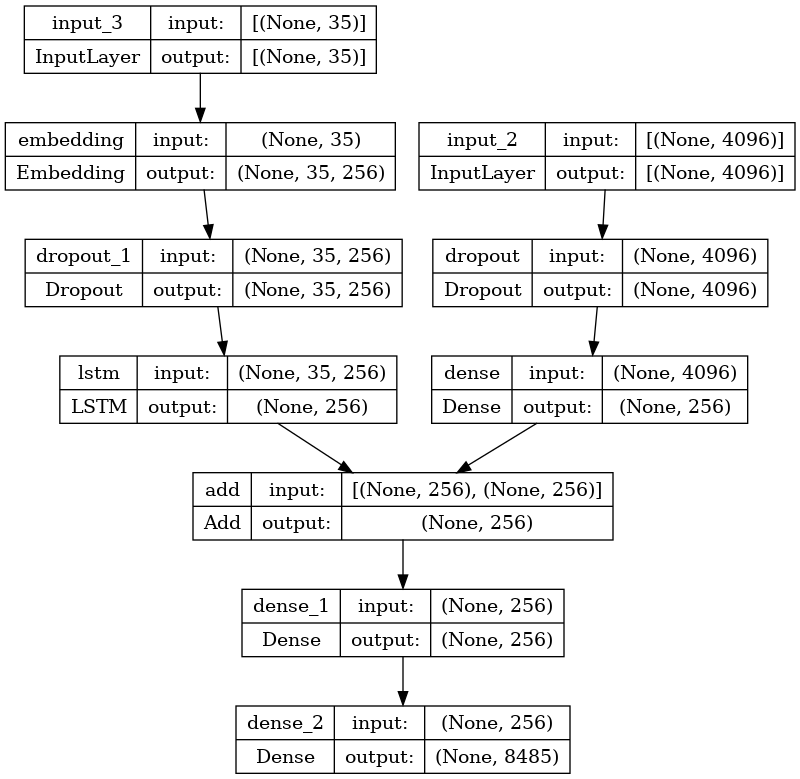

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

* <b>shape=(4096,)</b> - output length of the features from the VGG model

* <b>Dense</b> - single dimension linear layer array

* <b>Dropout()</b> - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

* <b>model.compile()</b> - compilation of the model

* <b>loss=’sparse_categorical_crossentropy’</b> - loss function for category outputs

* <b>optimizer=’adam’</b> - automatically adjust the learning rate for the model over the number of epochs

* Model plot shows the concatenation of the inputs and outputs into a single layer

* Feature extraction of image was already done using VGG, no CNN model was needed in this step

Now let us train the model.

In [24]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 67s 294ms/step - loss: 2.1936


* <b>steps = len(train) // batch_size</b> - back propagation and fetch the next data

* Loss decreases gradually over the iterations

* Increase the number of epochs for better results

* Assign the number of epochs and batch size accordingly for quicker results

You can save the model in the working directory for reuse.

In [25]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

* Convert the predicted index from the model into a word

In [36]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

* Caption generator appending all the words for an image

* The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

Now we validate the data using BLEU Score.

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540576
BLEU-2: 0.312694


* BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens

* The reference text contains all the words appended from the captions data (actual_captions)

* A BLEU Score more than 0.4 is considered a good result, for a better score increase the number of epochs accordingly

## Visualize the Results

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

* Image caption generator defined

* First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing with each other on the edge of the road endseq


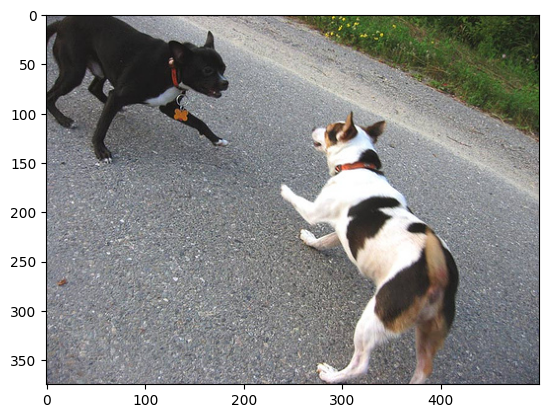

In [38]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
--------------------Predicted--------------------
startseq man wearing hat and hat starring at his head endseq


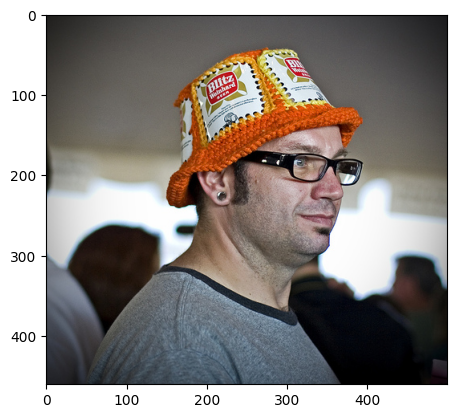

In [42]:
generate_caption("1007129816_e794419615.jpg")

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq little girl in red hat climbs through red ropes endseq


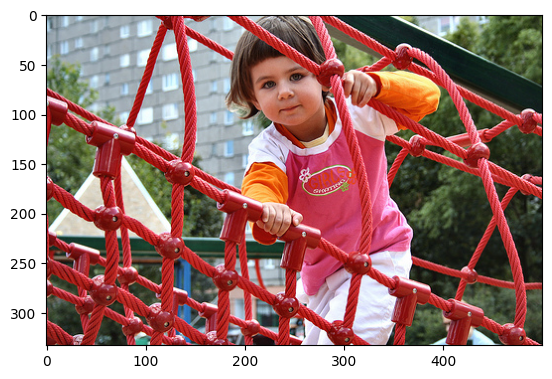

In [41]:
generate_caption("1007320043_627395c3d8.jpg")

## Test with Real Image

In [33]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

* VGG model is used for feature extraction of the image

'startseq woman in pink jacket is sitting on wooden bench endseq'

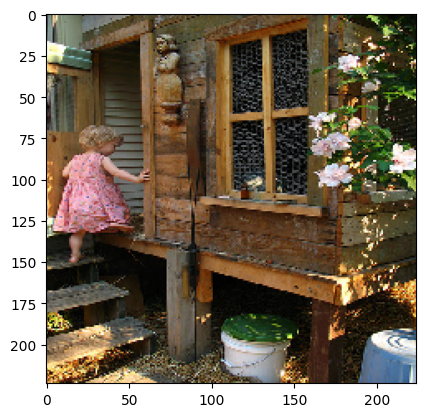

In [43]:
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
plt.imshow(image)
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

## Final Thoughts

* Training the model by increasing the no. of epochs can give better and more accurate results

* Processing large amount of data can take a lot of time and system resource

* The no. of layers of the model can be increased if you want to process large dataset like <b>flickr32k</b>

* Instead of VGG16, we can also use CNN model to extract the image features